# [CS 4476/6476 Project 3: Local Feature Matching](https://sites.google.com/view/cs4476-6476-sp2020)

This iPython notebook:  
(1) Loads and resizes images  
(2) Finds interest points in those images                 (you code this)  
(3) Describes each interest point with a local feature    (you code this)  
(4) Finds matching features                               (you code this)  
(5) Visualizes the matches  
(6) Evaluates the matches based on ground truth correspondences  

## Setup

In [12]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from utils import *
from student_feature_matching import match_features, pca, accelerated_matching
from student_sift import get_features
from student_harris import get_interest_points
from IPython.core.debugger import set_trace


from proj3_unit_tests.harris_unit_test import (
    test_get_gradients,
    test_get_gradients2,
    test_gaussian_kernel, 
    test_second_moment, 
    test_corner_response, 
    test_get_interest_points,
    test_find_single_valid_corner,
    verify
)
from proj3_unit_tests.sift_unit_test import (
    test_get_magnitudes_and_orientations,
    test_get_feat_vec,
    test_get_features, 
)

from proj3_unit_tests.feature_match_test import (
    test_compute_dists,
    test_feature_matching,
    test_pca
)

# Notre Dame
# image1 = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg')
# image2 = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg')
# eval_file = '../data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'

# # # Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
# image1 = load_image('../data/Mount Rushmore/9021235130_7c2acd9554_o.jpg')
# image2 = load_image('../data/Mount Rushmore/9318872612_a255c874fb_o.jpg')
# eval_file = '../data/Mount Rushmore/9021235130_7c2acd9554_o_to_9318872612_a255c874fb_o.pkl'

# Episcopal Gaudi -- This pair is relatively difficult
image1 = load_image('../data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg')
image2 = load_image('../data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg')
eval_file = '../data/Episcopal Gaudi/4386465943_8cf9776378_o_to_3743214471_1b5bbfda98_o.pkl'

                    
scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

n_pts = 1500 # width and height of each local feature, in pixels. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Find distinctive points in each image (Szeliski 4.1.1)
### These are the results using the ground truth points

<IPython.core.display.Javascript object>


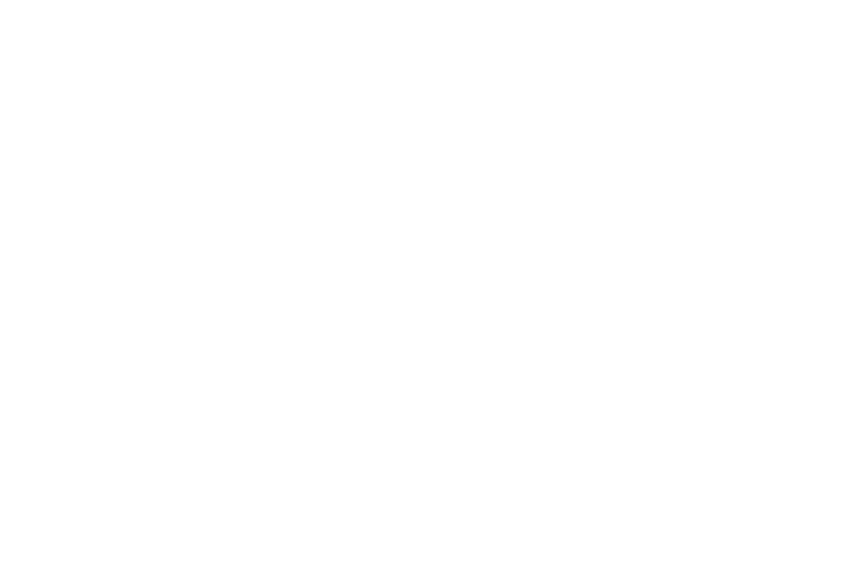

<IPython.core.display.Javascript object>


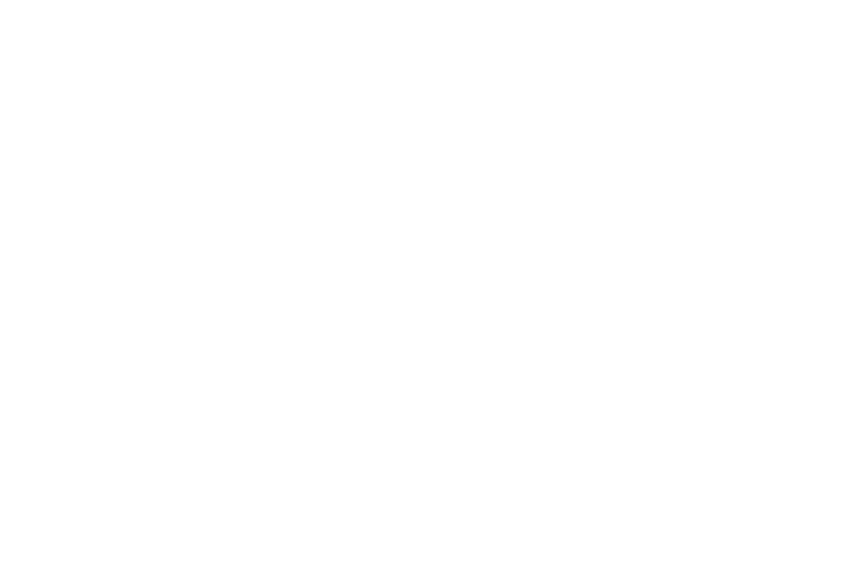

146 corners in image 1, 146 corners in image 2


<IPython.core.display.Javascript object>


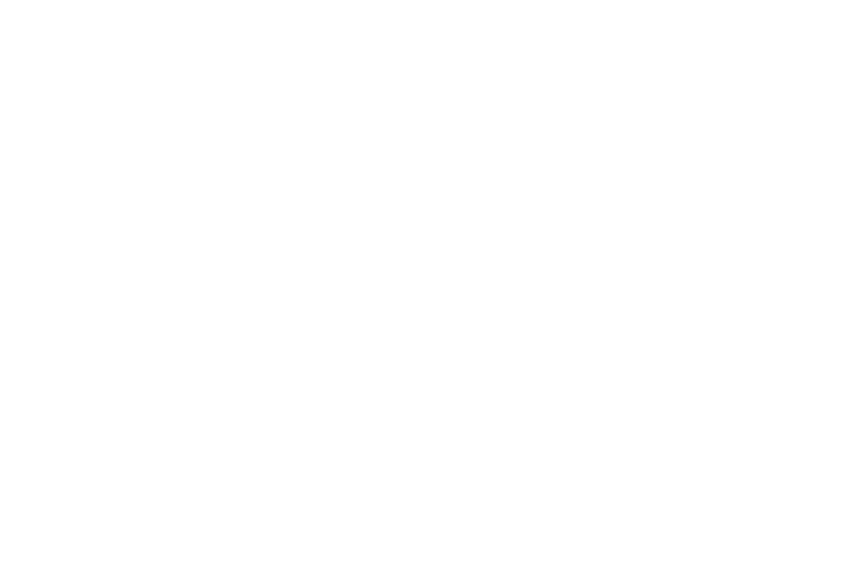

<IPython.core.display.Javascript object>


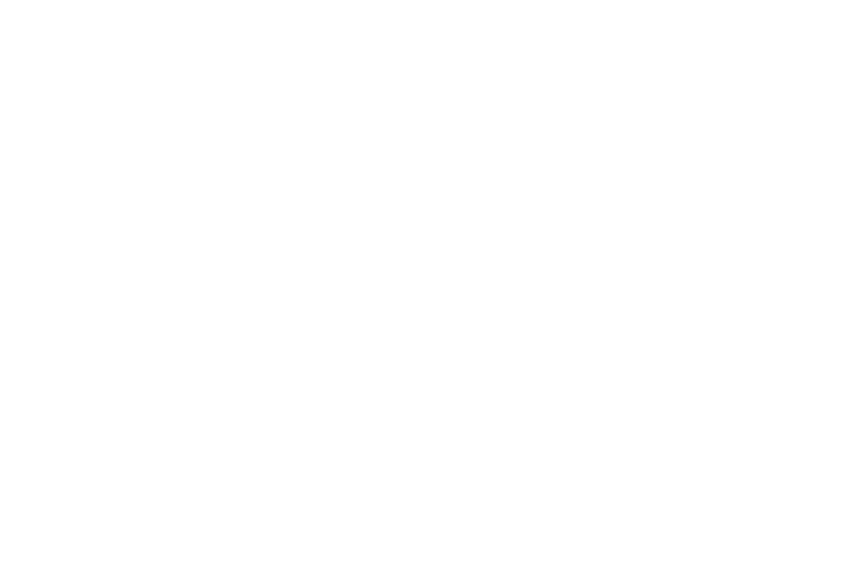

In [13]:
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)
# plt.figure(); plt.imshow(image1_bw)
# Visualize the interest points
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

### This is where you implement and observe your results from get interest points

#### First some unit tests

In [14]:
## Verify each step in the code, this will check if your implementation is correct or not.

## Do not modify the constructor of any function (i.e. to take some custom arguments
## as input)
    
print("Gaussian Kernel:", verify(test_gaussian_kernel))
print('Gradients test 1:', verify(test_get_gradients))
print('Gradients test 2:', verify(test_get_gradients2))
print('Second Moments:', verify(test_second_moment))
print('Corner Response:', verify(test_corner_response))

get_gaussian_kernel
get_gaussian_kernel
Gaussian Kernel: "Correct"
my_filter2D
my_filter2D
get_gradients, ixshape and iy shape
(8, 6)
(8, 6)
Gradients test 1: "Correct"
my_filter2D
my_filter2D
get_gradients, ixshape and iy shape
(19, 19)
(19, 19)
Gradients test 2: "Correct"
get_gaussian_kernel
second_moments
(3, 3)
(3, 3)
(3, 3)
get_gaussian_kernel
my_filter2D
my_filter2D
my_filter2D
second_moments
(3, 3)
(3, 3)
(3, 3)
Second Moments: "Correct"
corner response
3 3
Corner Response: "Correct"


#### Now run it all together

my_filter2D
my_filter2D
get_gradients, ixshape and iy shape
(600, 800)
(600, 800)
get_gaussian_kernel
my_filter2D
my_filter2D
my_filter2D
second_moments
(600, 800)
(600, 800)
(600, 800)
corner response
600 800
non_max_suppression
600 800
remove_border_vals, xlen, ylen and clen
457856
457856
457856
sortedc
[ 57548  57549  58332 ... 325994 132783 319844]
n_pts
1500
[324 325 324 ... 642 295 764]
[ 81  81  82 ... 423 177 415]
1500
finish
my_filter2D
my_filter2D
get_gradients, ixshape and iy shape
(900, 1350)
(900, 1350)
get_gaussian_kernel
my_filter2D
my_filter2D
my_filter2D
second_moments
(900, 1350)
(900, 1350)
(900, 1350)
corner response
900 1350
non_max_suppression
900 1350
remove_border_vals, xlen, ylen and clen
1179256
1179256
1179256
sortedc
[ 264779  266113  266112 ... 1136314  610996 1069768]
n_pts
1500
[ 655  655  654 ... 1088   32 1242]
[206 207 207 ... 859 466 809]
1500
finish


<IPython.core.display.Javascript object>


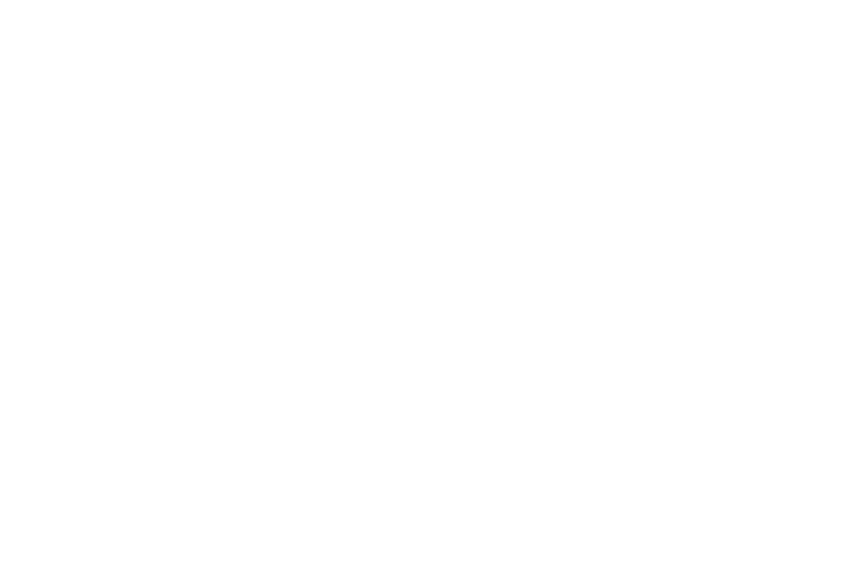

<IPython.core.display.Javascript object>


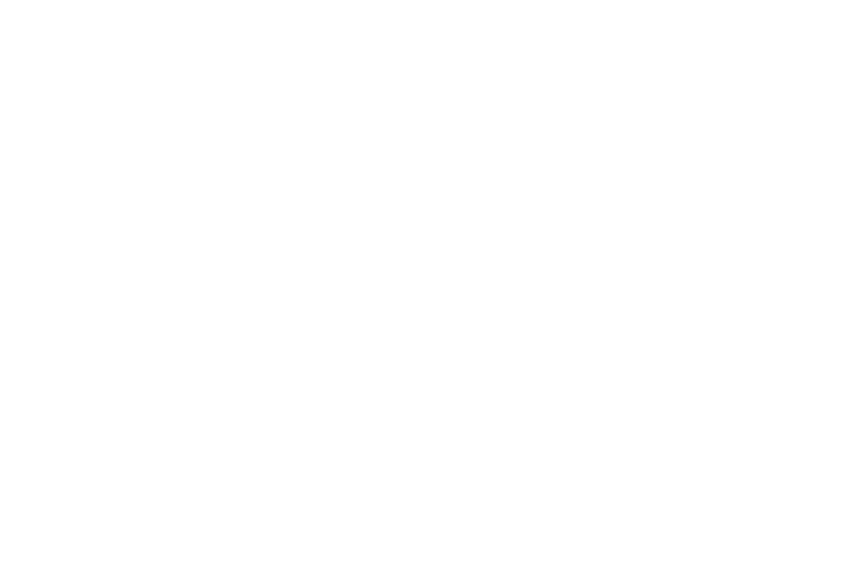

1500 corners in image 1, 1500 corners in image 2


<IPython.core.display.Javascript object>


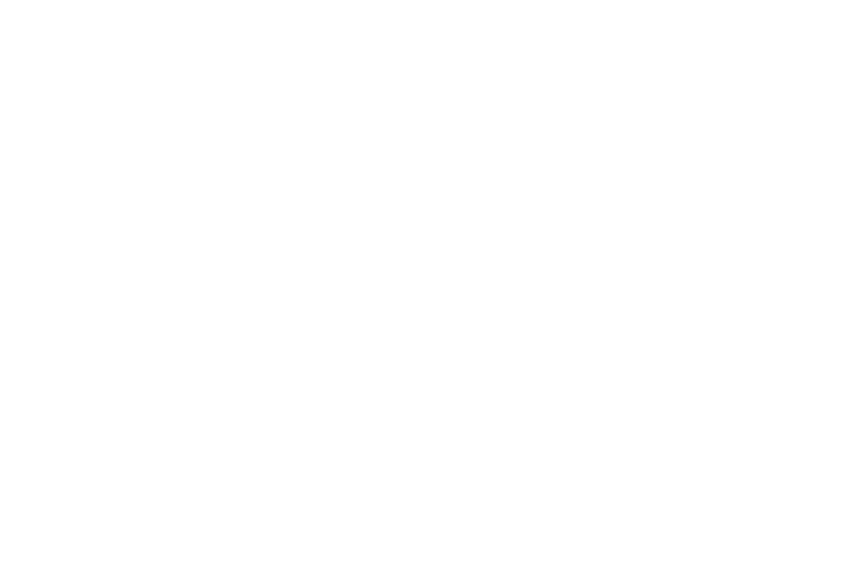

<IPython.core.display.Javascript object>


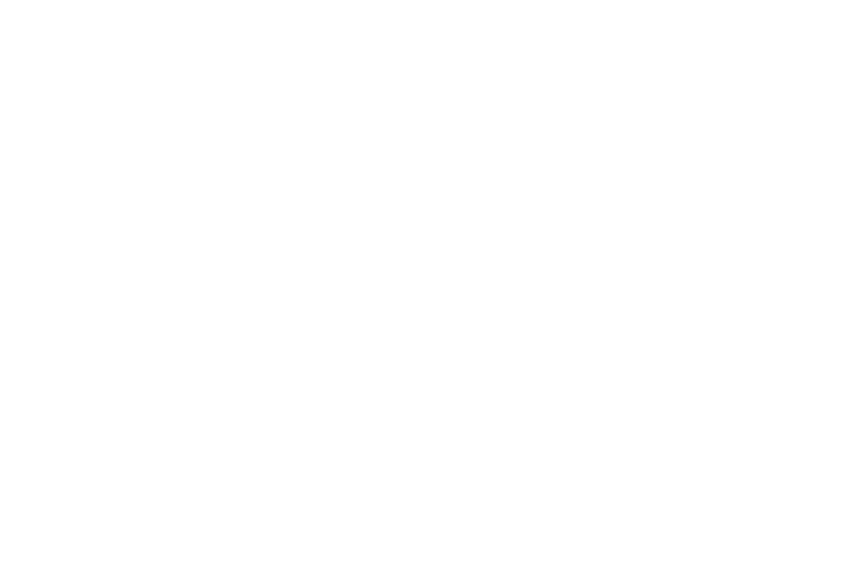

In [15]:
x1, y1, R1, _= get_interest_points(image1_bw, n_pts)
x2, y2, R2, _= get_interest_points(image2_bw, n_pts)
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

In [16]:
print('Interest Points:', verify(test_get_interest_points))
print('Interest Points Single Corner:', verify(test_find_single_valid_corner))

my_filter2D
my_filter2D
get_gradients, ixshape and iy shape
(19, 19)
(19, 19)
get_gaussian_kernel
my_filter2D
my_filter2D
my_filter2D
second_moments
(19, 19)
(19, 19)
(19, 19)
corner response
19 19
non_max_suppression
19 19
remove_border_vals, xlen, ylen and clen
9
9
9
sortedc
[4 7 5 3 1 8 6 2 0]
n_pts
1500
[ 9  9 10  8  9 10  8 10  8]
[ 9 10  9  9  8 10 10  8  8]
9
finish
Interest Points: "Correct"
my_filter2D
my_filter2D
get_gradients, ixshape and iy shape
(25, 25)
(25, 25)
get_gaussian_kernel
my_filter2D
my_filter2D
my_filter2D
second_moments
(25, 25)
(25, 25)
(25, 25)
corner response
25 25
non_max_suppression
25 25
remove_border_vals, xlen, ylen and clen
81
81
81
sortedc
[26 25 17 35 34 16 44  8 24 43  7 15 33 42  6 53 52 23 14 32 51 62 61 41
  5 60 22 31 13 50 40  4 59 71 70 69 68 49 21 80 79 30 12 39  3 78 48 77
 11 66 67 72 73 74 10  9 18 75 76  2  1 65 20 19 64 38 37 36 45 46 47 54
 29 28 27 55 56 57 58 63  0]
n_pts
1500
[16 15 16 16 15 15 16 16 14 15 15 14 14 14 14 16 15 13 13

#### This is where you will code the functions in student_sift.py. Run the following cell to test your implementation

In [17]:
print("Magnitudes and Orientations:", verify(test_get_magnitudes_and_orientations))
print('Feature Vector', verify(test_get_feat_vec))
print('All Feature Vectors', verify(test_get_features))

Magnitudes and Orientations: "Correct"
Feature Vector "Correct"
my_filter2D
my_filter2D
get_gradients, ixshape and iy shape
(20, 20)
(20, 20)
my_filter2D
my_filter2D
get_gradients, ixshape and iy shape
(20, 20)
(20, 20)
All Feature Vectors "Correct"


#### Collect features from our image pair

In [18]:
feature_width = 16
image1_features = get_features(image1_bw, x1, y1, feature_width)
image2_features = get_features(image2_bw, x2, y2, feature_width)

my_filter2D
my_filter2D
get_gradients, ixshape and iy shape
(600, 800)
(600, 800)
my_filter2D
my_filter2D
get_gradients, ixshape and iy shape
(900, 1350)
(900, 1350)


## Match features (Szeliski 4.1.3)

#### Complete compute_feature_distances() and feature_matching() in student_feature_matching.py. The following cell will test your implementations

In [19]:
print("Feature Distances:", verify(test_compute_dists))
print('Matches:', verify(test_feature_matching))

Feature Distances: "Correct"
[[2 1 3 0]
 [3 2 0 1]
 [0 3 1 2]
 [1 0 2 3]]
[[0.26101724 1.21742762 1.58656169 1.98271985]
 [0.26101724 1.21742762 1.58656169 1.98271985]
 [0.26101724 1.21742762 1.58656169 1.98271985]
 [0.26101724 1.21742762 1.58656169 1.98271985]]
[0.21440062 0.21440062 0.21440062 0.21440062]
[[0]
 [1]
 [2]
 [3]]
4
[[0 0]
 [0 0]
 [0 0]
 [0 0]]
[[0 2]
 [0 0]
 [0 0]
 [0 0]]
[[0 2]
 [1 3]
 [0 0]
 [0 0]]
[[0 2]
 [1 3]
 [2 0]
 [0 0]]
[[0 2]
 [1 3]
 [2 0]
 [3 1]]
[[0 2]
 [1 3]
 [2 0]
 [3 1]]
Matches: "Correct"


#### Match features for our image pair

In [20]:
start = time.time()
matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
end = time.time()
unoptimized = end - start
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
print('Time Elapsed: {}'.format(unoptimized))

[[   5  584 1269 ... 1217 1254 1401]
 [ 506 1424  418 ... 1217 1254 1401]
 [ 949 1117 1345 ... 1217 1254 1401]
 ...
 [ 739  527  285 ... 1217 1254 1401]
 [1149 1054  899 ...  605  841 1277]
 [1277  841  605 ... 1217 1254 1401]]
[[1.14939376e-04 1.63485514e-04 2.43835637e-04 ... 3.21501966e-01
  3.28525971e-01 3.65491398e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.21493424e-01
  3.28517612e-01 3.65483885e-01]
 [1.04678197e-04 2.07611686e-04 6.50428114e-04 ... 3.19633791e-01
  3.26657929e-01 3.63623968e-01]
 ...
 [5.10894598e-03 5.55493120e-03 1.04909887e-02 ... 3.48328324e-01
  3.54821675e-01 3.89298175e-01]
 [2.28357903e-05 5.08586959e-04 9.92355100e-04 ... 2.50687810e-01
  2.52137179e-01 2.55383865e-01]
 [7.85808102e-02 8.32200011e-02 8.53114754e-02 ... 4.12524008e-01
  4.18021360e-01 4.47656683e-01]]
[0.70305542        nan 0.50420185 ... 0.91971364 0.04490046 0.9442539 ]
[[   0]
 [   2]
 [   4]
 [   6]
 [   7]
 [   9]
 [  10]
 [  12]
 [  14]
 [  15]
 [  17]
 [  19]
 [  

C:\Users\Wenyue Wang\Documents\Spring 2020\CS 6476\HW\HW3\proj3_code\student_feature_matching.py:77: RuntimeWarning: invalid value encountered in true_divide
  confidences = nearest_n / second_n
C:\Users\Wenyue Wang\Documents\Spring 2020\CS 6476\HW\HW3\proj3_code\student_feature_matching.py:80: RuntimeWarning: invalid value encountered in less
  ind = np.argwhere(confidences < thres)


## Visualization

You might want to set 'num_pts_to_visualize' and 'num_pts_to_evaluate' to some constant (e.g. 100) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. You can comment out one of both of them if you prefer.

<IPython.core.display.Javascript object>


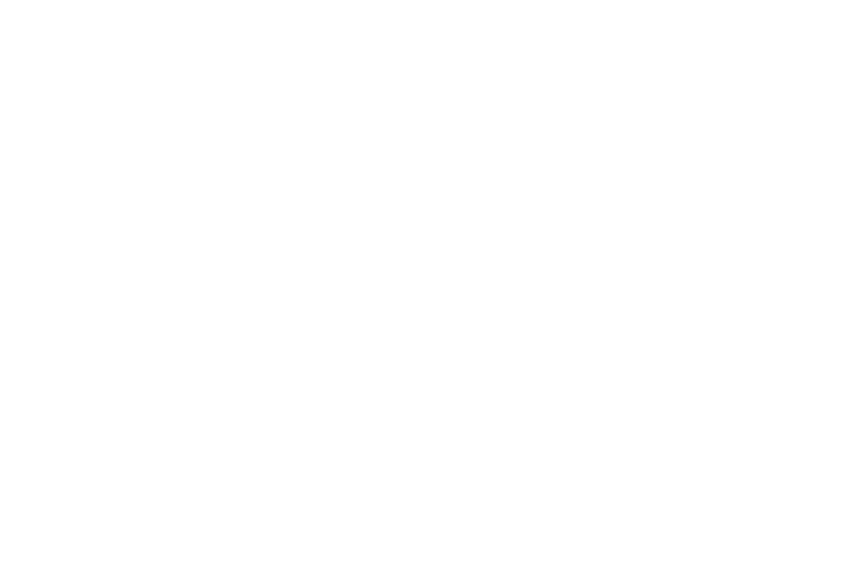

<IPython.core.display.Javascript object>


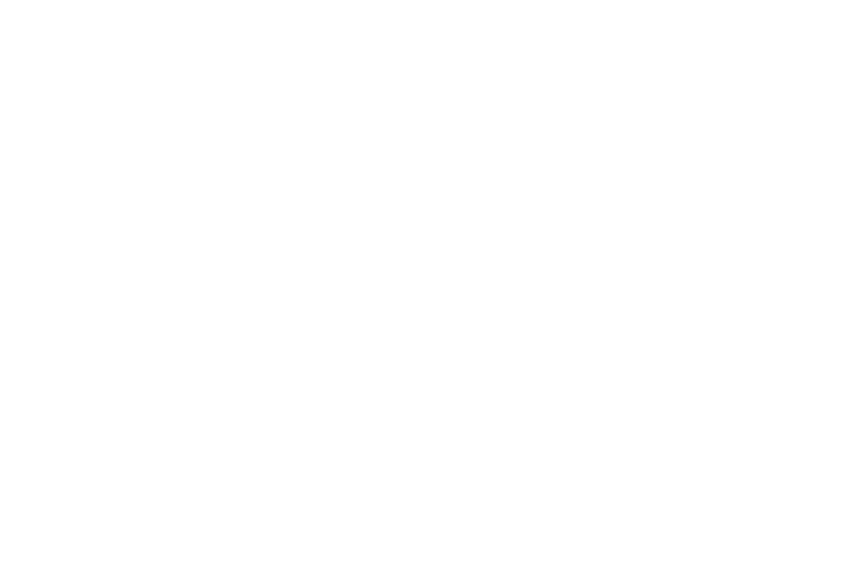

<IPython.core.display.Javascript object>


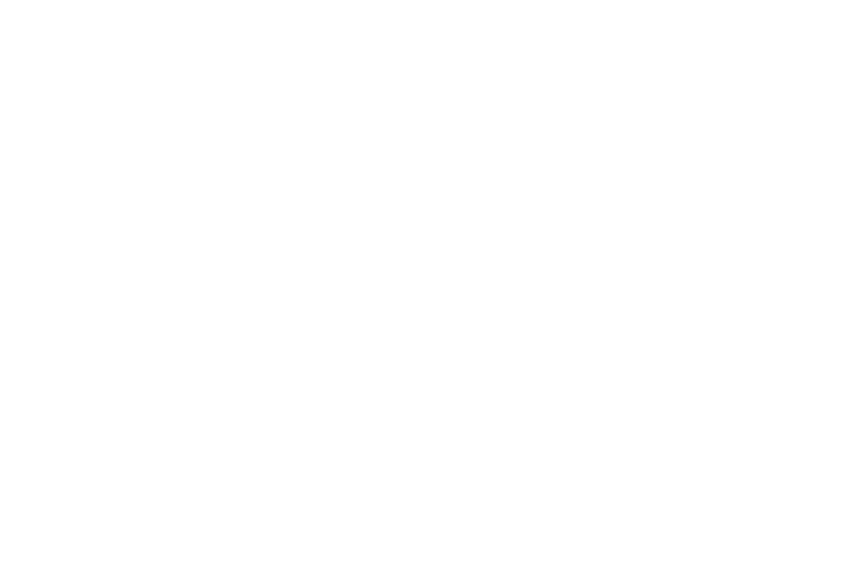

<IPython.core.display.Javascript object>


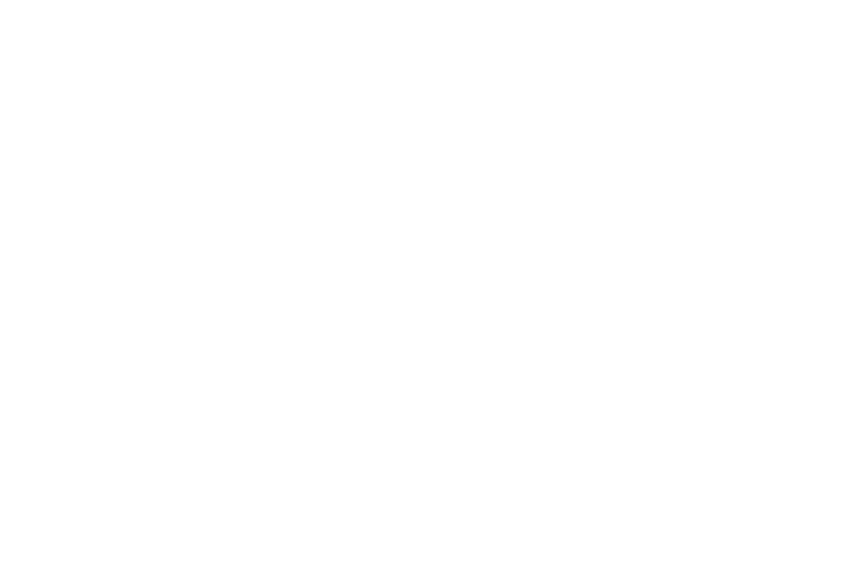

In [21]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles.png', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines.png', dpi=1000)

Comment out the function below if you are not testing on the Notre Dame, Episcopal Gaudi, and Mount Rushmore image pairs--this evaluation function will only work for those which have ground truth available.  
  
You can use `annotate_correspondences/collect_ground_truth_corr.py` to build the ground truth for other image pairs if you want, but it's very tedious. It would be a great service to the class for future years, though!

You found 100/100 required matches
Accuracy = 0.000000


<IPython.core.display.Javascript object>


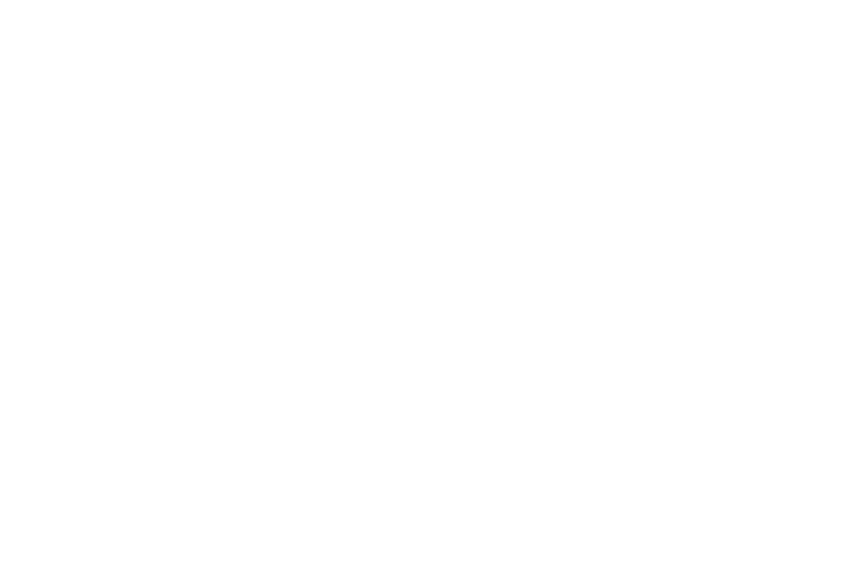

<IPython.core.display.Javascript object>


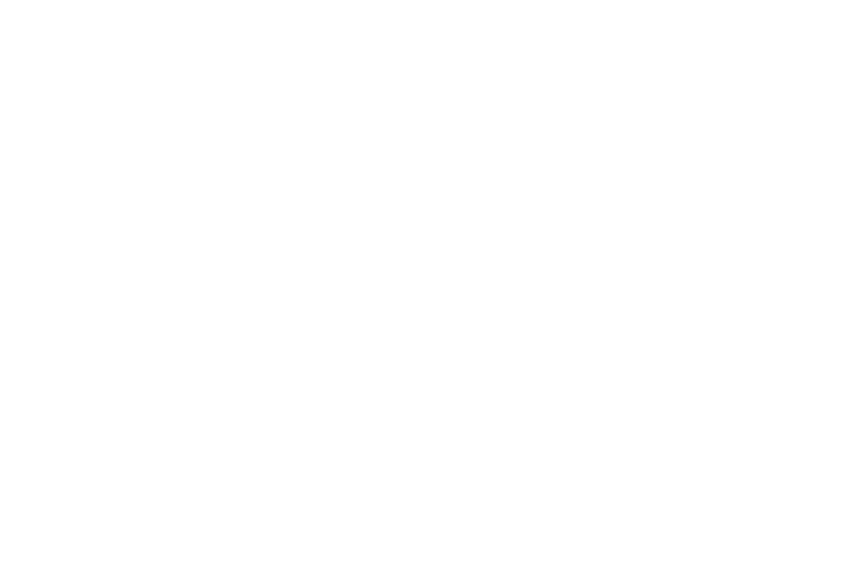

In [22]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval.png', dpi=1000)

## Bells and Whistles tests

### PCA

In [23]:
print("PCA: ", verify(test_pca))

NotImplementedError: `pca` function in `student_feature_matching.py` needs to be implemented

In [24]:
n_components = 24
start = time.time()
reduced_image1_features, reduced_image2_features = pca(image1_features, image2_features, n_components)
matches, confidences = match_features(reduced_image1_features, reduced_image2_features, x1, y1, x2, y2)
end = time.time()
pca_optimized = end - start
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
print('Time Elapsed (PCA): {}'.format(pca_optimized))
print('Time Elapsed (no optimization): {}'.format(unoptimized))

NotImplementedError: `pca` function in `student_feature_matching.py` needs to be implemented

In [ ]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles.png', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines.png', dpi=1000)

In [ ]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval.png', dpi=1000)

### Accelerated Matching

In [ ]:
start = time.time()
matches, confidences = accelerated_matching(image1_features, image2_features, x1, y1, x2, y2)
end = time.time()
accelerated = end - start
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
print('Time Elapsed (Accelerated): {}'.format(accelerated))
print('Time Elapsed (PCA): {}'.format(pca_optimized))
print('Time Elapsed (no optimization): {}'.format(unoptimized))

In [ ]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles.png', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines.png', dpi=1000)

In [ ]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval.png', dpi=1000)